In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "root@123",
                            database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query=""" select distinct(customer_city) from  customers """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [36]:
query=""" select count(order_id) as total_order from orders where order_purchase_timestamp =2017 """
cur.execute(query)
data= cur.fetchall()
'total order placed in 2017 ',data[0][0]


('total order placed in 2017 ', 45101)

# Find the total sales per category.

In [17]:
query=""" select  upper(products.product_category) , 
round(sum(payments.payment_value) ,2) as total_Sales
from order_items join products
on order_items.product_id = products.product_id
join payments
on order_items.order_id= payments.order_id
group by products.product_category  """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns= ["product_category" ,"total_sales"])
df

,product_category,total_sales
0,PERFUMERY,813891.15
1,FURNITURE DECORATION,2330312.52
2,TELEPHONY,795818.94
3,BED TABLE BATH,2753869.88
4,AUTOMOTIVE,1333835.40
...,...,...
69,CDS MUSIC DVDS,2201.70
70,LA CUISINE,4280.59
71,FASHION CHILDREN'S CLOTHING,971.32
72,PC GAMER,3878.49


# Calculate the percentage of orders that were paid in installments.

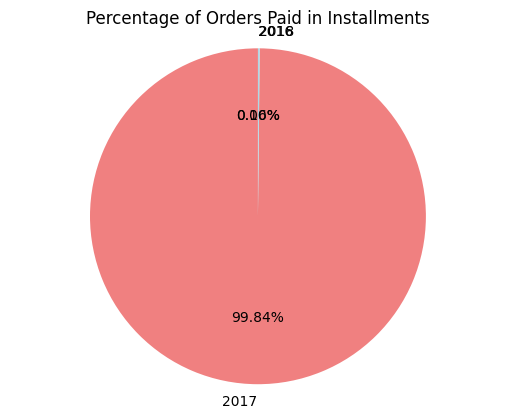

In [31]:
query=""" select (sum(case when payment_installments >=1 then 1 else 0 end ))/count(*) *100 as paid_installment 
from payments;  """
cur.execute(query)
data= cur.fetchall()
' The percentage of orders that we paid in installments is ', data

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=['lightblue', 'lightcoral'])

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Add title
plt.title('Percentage of Orders Paid in Installments')

# Show the plot
plt.show()

# Count the number of customers from each state.

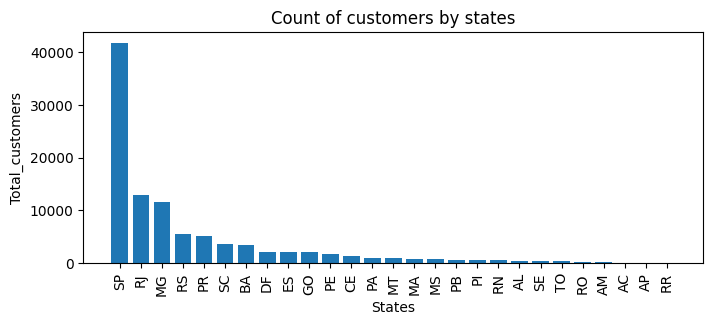

In [18]:
query=""" select customer_state , count(customer_id)as total_customers  from customers
group by customer_state;"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data , columns=['State', 'Total_customers'])
df=df.sort_values(by ='Total_customers',ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['State'], df['Total_customers'])
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Total_customers')
plt.title('Count of customers by states')
plt.show()

# Calculate the number of orders per month in 2018.

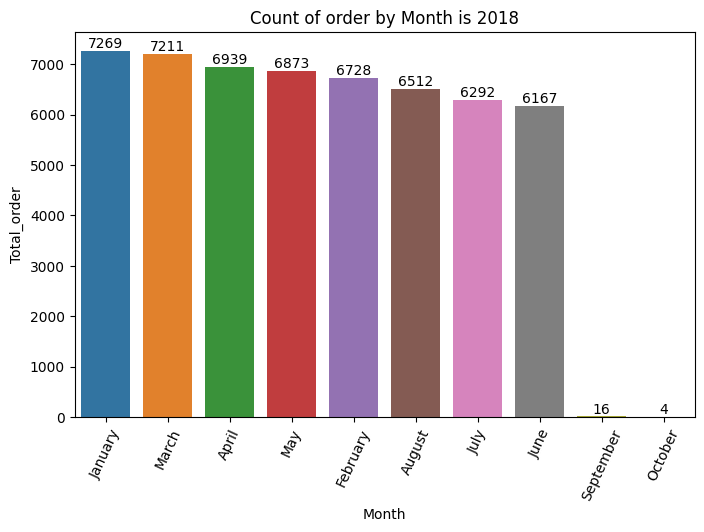

In [20]:
query="""select monthname(order_purchase_timestamp ) as month, count(order_id) from orders
where year(order_purchase_timestamp)= 2018
group by month;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data , columns=['Month', 'Total_order'])
df=df.sort_values(by ='Total_order',ascending=False)
plt.figure(figsize=(8,5))
a=sns.barplot(x =df['Month'], y=df['Total_order'],data=df)
a.bar_label(a.containers[0])
plt.xticks(rotation=65)
plt.title('Count of order by Month is 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

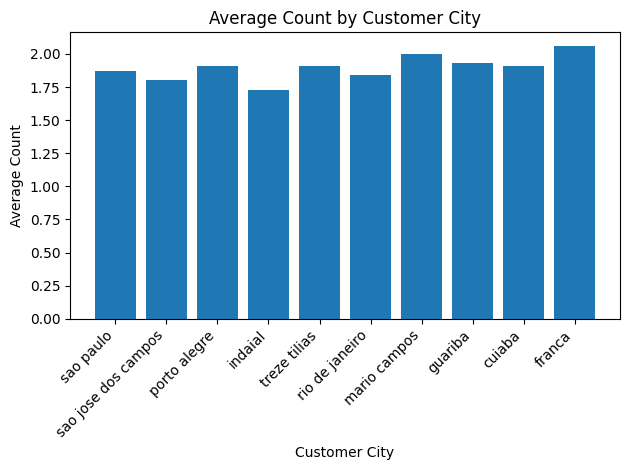

In [29]:
query="""with count_per_order as (select orders.order_id, orders.customer_id,count(order_items.order_id) as order_count
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id) 
select customers.customer_city ,round( avg(count_per_order.order_count),2) as avg_orders
from customers join count_per_order
on customers.customer_id= count_per_order.customer_id
group by customers.customer_city;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data , columns=['Customer_city', 'Average_count'])
df= df.head(10)
plt.bar(df['Customer_city'], df['Average_count'])

plt.xticks(rotation=45, ha='right')

plt.title('Average Count by Customer City')
plt.xlabel('Customer City')
plt.ylabel('Average Count')

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

In [9]:
query="""select  upper(products.product_category) , 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales 
from order_items join products
on order_items.product_id = products.product_id
join payments
on order_items.order_id= payments.order_id
group by products.product_category;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data , columns=['Product_category', 'Sales_percentage'])
df

,Product_category,Sales_percentage
0,PERFUMERY,5.08
1,FURNITURE DECORATION,14.56
2,TELEPHONY,4.97
3,BED TABLE BATH,17.20
4,AUTOMOTIVE,8.33
...,...,...
69,CDS MUSIC DVDS,0.01
70,LA CUISINE,0.03
71,FASHION CHILDREN'S CLOTHING,0.01
72,PC GAMER,0.02


# Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
query="""select products.product_category,count(order_items.product_id)as total_count_of_product,
round(avg(order_items.price),2) as avg_price 
from products join order_items
on products.product_id =order_items.product_id
group by products.product_category;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data,columns=['category', 'order_count','Price'])
df
arr1=df['order_count']
arr2=df['Price']
np.corrcoef(arr1,arr2)

array([[ 1.        , -0.10816594],
       [-0.10816594,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.


In [16]:
query="""select *, dense_rank() over(order by revenue desc)as rn from 
(select order_items.seller_id, round(sum(payments.payment_value),2) as revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=['Seller_id','Revenue','Rank'])
df
 

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,820110.01,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,500071.48,2
2,1f50f920176fa81dab994f9023523100,483615.04,3
3,4a3ca9315b744ce9f8e9374361493884,481240.70,4
4,53243585a1d6dc2643021fd1853d8905,478819.88,5
...,...,...,...
3090,3ac588cd562971392504a9e17130c40b,19.29,3080
3091,ad14615bdd492b01b0d97922e87cb87f,19.21,3081
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3082
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3083


# Calculate the moving average of order values for each customer over their order history.

In [4]:
query="""select customer_id,order_purchase_timestamp ,payment ,
avg (payment) 
over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg 
from 
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
from orders join payments
on orders.order_id = payments.order_id) as x ; """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=['customer_id','Order_purchase_timestamp','Payments','Moving_avg'])
df


,customer_id,Order_purchase_timestamp,Payments,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [6]:
query="""select years, months ,payment, sum(payment)
over(order by years, months ) cumulative from 
(select year(orders.order_purchase_timestamp) as years , 
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2)  as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years , months) as x; """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=['Years ','Months','Payments','Cumulative '])
df


,Years,Months,Payments,Cumulative
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

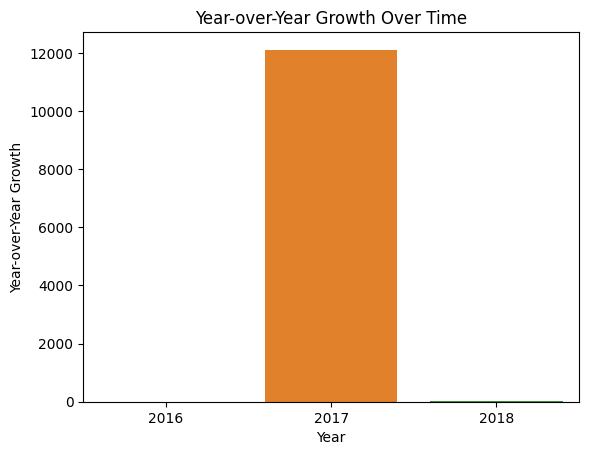

In [15]:
query="""with a as (select year(orders.order_purchase_timestamp) as years ,
round(sum(payments.payment_value),2)  as payment
from orders join payments
on orders.order_id = payments.order_id
group by years  order by years)
select years , 
round(((payment - lag(payment -1) over (order by years ))/lag(payment -1) over (order by years )) *100,2) as Year_over_year_growth
from a;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data, columns=['Year','Year_over_year_Growth'])
df
sns.barplot(x=df['Year'], y=df['Year_over_year_Growth'], data=df)
# plt.plot(df['Year'], df['Year_over_year_Growth'], marker='o')
plt.title('Year-over-Year Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Year-over-Year Growth')
plt.show()


                 

# Identify the top 3 customers who spent the most money in each year.

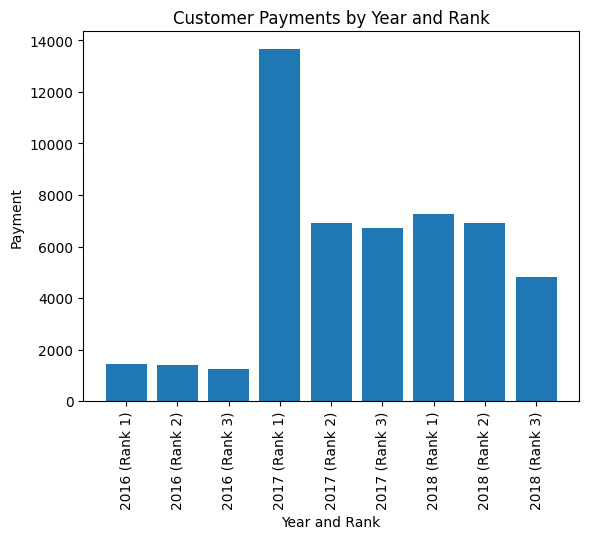

In [25]:
query="""select years, customer_id, payment, D_Rank
from 
(select year(orders.order_purchase_timestamp) as years , 
orders.customer_id,
sum(payments.payment_value) as payment ,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as D_Rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where D_Rank <= 3 ;"""
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data, columns=['Year','Customer_id','Payment','Rank'])
df
plt.bar(df['Year'].astype(str) + ' (Rank ' + df['Rank'].astype(str) + ')', df['Payment'])
plt.xticks(rotation=90)
plt.title('Customer Payments by Year and Rank')
plt.xlabel('Year and Rank')
plt.ylabel('Payment')
plt.show()